In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
from matplotlib.dates import MonthLocator, DateFormatter

### 2019-04-01 00:00:00 ~ 2020-06-01 00:00:00

In [2]:
# Read table
fdf = pd.read_csv('./table/190401-200531_prj_data.csv')

/Users/jaehyeonlee/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Check table date
print('min date : {}, max date : {}'.format(fdf['work_sdate'].min(), fdf['work_sdate'].max()))
print()
print('total table shape', fdf.shape)

# Get unique worker, checker list
worker_list = fdf['work_user'].unique()
checker_list = fdf['check_user'].unique()

print("Num of Worker: {}, Checker: {}".format(len(worker_list), len(checker_list)))
print()

# Datetime to YYYY-M-D
for d in ['work_sdate', 'work_edate', 'check_sdate', 'check_edate']:
    fdf[d] = pd.to_datetime(fdf[d]).dt.date

display(fdf.head(5))

min date : 2019-04-01 00:00:24, max date : 2020-05-31 23:59:11

total table shape (7073363, 18)
Num of Worker: 29732, Checker: 656



data_idx  prj_idx  project_id  invalid_yn  problem_yn  work_object_number  \
0  16640431      930      1091.0         0.0           0                 1.0   
1  16640433      930      1091.0         0.0           0                 1.0   
2  16640436      930      1091.0         0.0           0                 1.0   
3  16640437      930      1091.0         0.0           0                 1.0   
4  16640439      930      1091.0         0.0           0                 1.0   

   work_user  work_sdate  work_edate work_point_type_cd  work_point  \
0      11343  2019-04-16  2019-04-16         POINT_SAVE       500.0   
1      11343  2019-04-16  2019-04-16         POINT_SAVE       500.0   
2      11343  2019-04-16  2019-04-16         POINT_SAVE       500.0   
3      11343  2019-04-16  2019-04-16         POINT_SAVE       500.0   
4      11343  2019-04-16  2019-04-16         POINT_SAVE       500.0   

   check_user check_sdate check_edate check_point_type_cd  check_point  \
0     17642.0  2019-04-16  2019-04-16          POINT_SAVE         50.0   
1     17642.0  2019-04-16  2019-04-16          POINT_SAVE         50.0   
2     17642.0  2019-04-16  2019-04-16          POINT_SAVE         50.0   
3     17642.0  2019-04-16  2019-04-16          POINT_SAVE         50.0   
4     17642.0  2019-04-16  2019-04-16          POINT_SAVE         50.0   

  platform  hold_yn  
0  android        0  
1  android        0  
2  android        0  
3  android        0  
4  android        0

### Churn Member
- 3개월간 작업 및 검수를 수행하지 않은 회원

In [4]:
def get_churn_member(final_df, member_list, churn_days, last_date, is_worker):
    chr_members, chr_sdates, chr_edates, chr_periods = [], [], [], []
        
    for i, m in enumerate(member_list):
        # get unique date
        if is_worker: # worker
            df = final_df[final_df['work_user'] == m].reset_index(drop=True)
            df = df.sort_values(by=['work_sdate']).reset_index(drop=True)
            vc_df = df['work_sdate'].value_counts().sort_index()
        else: # checker
            df = final_df[final_df['check_user'] == m].reset_index(drop=True)
            df = df.sort_values(by=['check_sdate']).reset_index(drop=True)
            vc_df = df['check_sdate'].value_counts().sort_index()

        unq_date = vc_df.index
        if len(unq_date) > 1:
            for d in range(len(unq_date) - 1):
                chr_period = (unq_date[d+1] - unq_date[d]).days
                # 90일간 접속하지 않은 경우
                if chr_period > churn_days:
                    chr_members.append(m)
                    chr_sdates.append(unq_date[d])
                    chr_edates.append(unq_date[d+1])
                    chr_periods.append(chr_period)

            # 해당 작업자 마지막 작업 일로부터 분석 기간 마지막 날짜까지의 day
            if (last_date - unq_date[-1]).days > churn_days:
                chr_members.append(m)
                chr_sdates.append(unq_date[-1])
                chr_edates.append(last_date)
                chr_periods.append((last_date - unq_date[-1]).days)
        
        # 하루 작업 이후 이탈
        elif len(unq_date) == 1:
            if (last_date - unq_date[0]).days > churn_days:                
                chr_members.append(m)
                chr_sdates.append(unq_date[0])
                chr_edates.append(last_date)
                chr_periods.append((last_date - unq_date[0]).days)
            
        # 작업 이력 없음
        elif len(unq_date) == 0:
            chr_members.append(m)
            chr_sdates.append(None)
            chr_edates.append(None)
            chr_periods.append(None)
            
        if (i+1) % 100 == 0:
            print('Get churn member info... {} / {}'.format(i+1, len(member_list)))
        
    # Make DataFrame
    churn_df = pd.DataFrame(data={'member_id': chr_members,
                                 'churn_sdate': chr_sdates,
                                 'churn_edate': chr_edates,
                                 'churn_period': chr_periods})

    return churn_df
    



In [5]:
# Get churn member
last_date = datetime.strptime('2020-06-01', '%Y-%m-%d').date()
churn_days = 90

# churn_worker_df = get_churn_member(fdf, worker_list, churn_days, last_date, True) # Worker
# churn_checker_df = get_churn_member(fdf, checker_list, churn_days, last_date, False) # Checker
# churn_worker_df.to_csv('./table/churn_worker_df.csv', index=False)
# churn_checker_df.to_csv('./table/churn_checker_df.csv', index=False)

### 이탈 회원 정보 merge

In [6]:
# Get total member table
member_df = pd.read_csv('./table/TB_MEMBER.csv')
churn_worker_df = pd.read_csv('./table/churn_worker_df.csv')
churn_checker_df = pd.read_csv('./table/churn_checker_df.csv')

# Get columns
member_df = member_df[['member_id', 'reg_date', 'member_type_cd', 'login_id', 'mem_class_cd', 'birthday', 'sms_receive_date', 'sms_receive_yn', 'email_receive_date', 'email_receive_yn',
                      'promotion_receive_agree_yn', 'promotion_receive_agree_date', 'promotion_receive_deny_date', 'last_login_date', 'last_login_platform']]
# Remove admin member
new_member = member_df[~member_df['member_type_cd'].isin(['ADMIN', 'SYSTEM'])].reset_index(drop=True)
print('Member table shape: ', new_member.shape)
print('Total member type: ', new_member['member_type_cd'].unique())

# Get churn member information
print('Before worker/checker shape: {}/{}'.format(churn_worker_df.shape, churn_checker_df.shape))
churn_worker_df = pd.merge(
    churn_worker_df,
    member_df[member_df['member_id'].isin(churn_worker_df['member_id'].unique())].reset_index(drop=True),
    on='member_id'
)
churn_checker_df = pd.merge(
    churn_checker_df,
    member_df[member_df['member_id'].isin(churn_checker_df['member_id'].unique())].reset_index(drop=True),
    on='member_id'
)
print('Merge worker/checker shape: {}/{}'.format(churn_worker_df.shape, churn_checker_df.shape))

# Data type preprocessing
for i in ['member_id', 'churn_period', 'sms_receive_yn', 'email_receive_yn', 'promotion_receive_agree_yn']:
    churn_worker_df[i] = pd.to_numeric(churn_worker_df[i], downcast='signed')
    churn_checker_df[i] = pd.to_numeric(churn_checker_df[i], downcast='signed')
    
for d in ['churn_sdate', 'churn_edate', 'reg_date', 'last_login_date']:
    churn_worker_df[d] = pd.to_datetime(churn_worker_df[d])
    churn_checker_df[d] = pd.to_datetime(churn_checker_df[d])

churn_worker_df = churn_worker_df.sort_values(by='churn_sdate').reset_index(drop=True)
churn_checker_df = churn_checker_df.sort_values(by='churn_sdate').reset_index(drop=True)

# # Save table
# churn_checker_df.to_csv('./table/churn_')

display(churn_worker_df.head(5), churn_checker_df.head(5))

/Users/jaehyeonlee/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7,24,26,27,35,42,46,51,52,53,67,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Member table shape:  (150582, 15)
Total member type:  ['CHECKER' 'WORKER' 'OPENER']
Before worker/checker shape: (18919, 4)/(520, 4)
Merge worker/checker shape: (18919, 18)/(519, 18)


member_id churn_sdate churn_edate  churn_period            reg_date  \
0      21504  2019-04-01  2020-06-01           427 2019-03-30 14:14:33   
1      21520  2019-04-01  2020-06-01           427 2019-03-31 22:48:15   
2      21537  2019-04-01  2020-06-01           427 2019-04-01 18:14:06   
3      20731  2019-04-01  2020-02-15           320 2019-02-13 17:33:19   
4      21530  2019-04-01  2020-06-01           427 2019-04-01 15:10:28   

  member_type_cd                login_id mem_class_cd    birthday  \
0         WORKER  Shinylee0923@gmail.com  BRONZE_PLUS  19860923.0   
1         WORKER    ojoonhee00@gmail.com      STARTER  20001011.0   
2         WORKER  mikekwak528i@gmail.com  BRONZE_PLUS  19820405.0   
3         WORKER        kkm156@naver.com  SILVER_PLUS  19910729.0   
4         WORKER       m00nh22@naver.com      STARTER  19790315.0   

      sms_receive_date  sms_receive_yn   email_receive_date  email_receive_yn  \
0                  NaN               1                  NaN                 1   
1                  NaN               1                  NaN                 1   
2                  NaN               1                  NaN                 1   
3                  NaN               0                  NaN                 1   
4  2020-02-08 15:32:19               1  2020-02-08 15:32:19                 1   

   promotion_receive_agree_yn promotion_receive_agree_date  \
0                           0                          NaN   
1                           0                          NaN   
2                           0                          NaN   
3                           0                          NaN   
4                           0                          NaN   

  promotion_receive_deny_date     last_login_date last_login_platform  
0         2019-03-30 14:14:33 2019-07-29 20:47:19                 ios  
1         2019-03-31 22:48:15 2019-04-17 11:38:00             android  
2         2019-04-01 18:14:06 2019-10-02 17:54:59                 ios  
3         2019-02-13 17:33:19 2020-02-15 00:15:15                 NaN  
4         2019-04-01 15:10:28 2020-02-08 15:31:56             android

member_id churn_sdate churn_edate  churn_period            reg_date  \
0      20672  2019-03-21  2020-06-01           438 2019-02-11 14:58:10   
1      18983  2019-03-26  2019-07-10           106 2018-12-04 23:18:37   
2      20587  2019-04-04  2020-06-01           424 2019-02-02 12:29:04   
3      20013  2019-04-08  2020-06-01           420 2019-01-03 09:57:11   
4      20012  2019-04-08  2020-06-01           420 2019-01-03 09:56:40   

  member_type_cd              login_id mem_class_cd    birthday  \
0        CHECKER   klo3927@estsoft.com  SILVER_PLUS  19960722.0   
1        CHECKER      slikek@naver.com    GOLD_PLUS  19820501.0   
2        CHECKER  news24@crowdworks.kr       BRONZE  19940502.0   
3        CHECKER  china2@crowdworks.kr    GOLD_PLUS         NaN   
4        CHECKER  china1@crowdworks.kr    GOLD_PLUS         NaN   

  sms_receive_date  sms_receive_yn email_receive_date  email_receive_yn  \
0              NaN               1                NaN                 1   
1              NaN               1                NaN                 1   
2              NaN               0                NaN                 0   
3              NaN               1                NaN                 1   
4              NaN               1                NaN                 1   

   promotion_receive_agree_yn promotion_receive_agree_date  \
0                           0                          NaN   
1                           0                          NaN   
2                           0                          NaN   
3                           0                          NaN   
4                           0                          NaN   

  promotion_receive_deny_date     last_login_date last_login_platform  
0         2019-02-11 14:58:10 2020-06-04 13:09:08                 ios  
1         2018-12-04 23:18:37 2020-05-27 20:45:24                 ios  
2         2019-02-02 12:29:04 2019-04-22 14:25:52                 NaN  
3         2019-01-03 09:57:11 2019-04-09 17:38:04                 NaN  
4         2019-01-03 09:56:40 2019-04-09 17:35:56                 NaN

### 이탈 회원 수

Unique churn member
Worker:  18409
Checker:  502

== Top 10 Worekr Churn Date ==
 2020-01-15    951
2020-01-14    743
2020-01-16    705
2020-01-17    506
2019-12-12    467
2019-12-11    420
2019-12-19    368
2020-01-21    342
2019-12-06    341
2020-02-04    332
Name: churn_sdate, dtype: int64

== Top 10 Checker Churn Date ==
 2019-12-06    16
2019-12-11    10
2019-12-12    10
2019-12-10    10
2019-12-09    10
2019-09-04     7
2019-10-16     7
2019-11-22     7
2019-12-16     6
2019-12-27     6
Name: churn_sdate, dtype: int64


/Users/jaehyeonlee/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


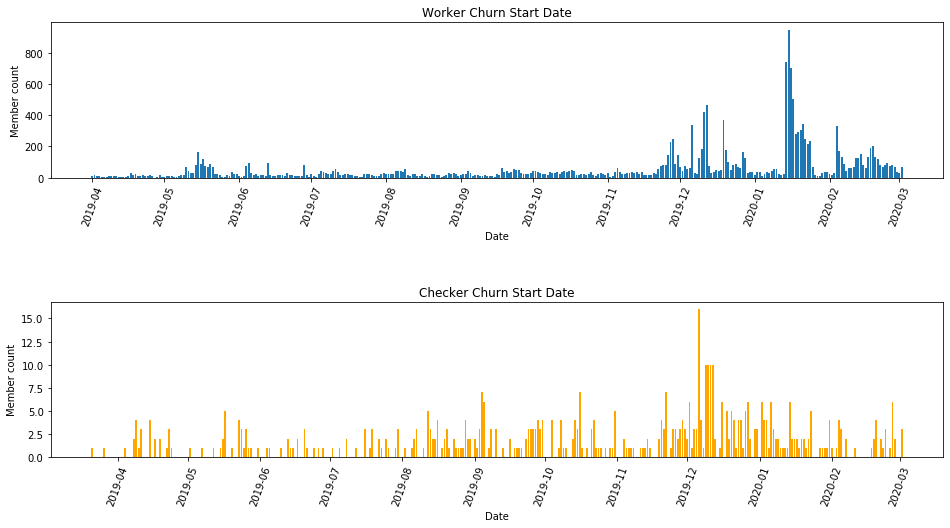

In [7]:
print('Unique churn member')
print("Worker: ", len(churn_worker_df['member_id'].unique()))
print("Checker: ", len(churn_checker_df['member_id'].unique()))
print()
print('== Top 10 Worekr Churn Date ==\n', churn_worker_df['churn_sdate'].value_counts()[:10])
print()
print('== Top 10 Checker Churn Date ==\n', churn_checker_df['churn_sdate'].value_counts()[:10])

fig = plt.figure(figsize=(16,8))
# Worker
churn_worker_vc = churn_worker_df['churn_sdate'].value_counts().sort_index()
worker_plot = fig.add_subplot(211)
fig.subplots_adjust(hspace=0.8)
worker_plot.bar(
    churn_worker_vc.index,
    churn_worker_vc)
worker_plot.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))
worker_plot.xaxis.set_major_locator(mdates.MonthLocator())
plt.title("Worker Churn Start Date")
plt.xlabel('Date')
plt.ylabel('Member count')
plt.xticks(rotation=70)

# Checker
churn_checker_vc = churn_checker_df['churn_sdate'].value_counts().sort_index()
checker_plot = fig.add_subplot(212)
checker_plot.bar(
    churn_checker_vc.index,
    churn_checker_vc,
    color='orange')
checker_plot.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))
checker_plot.xaxis.set_major_locator(mdates.MonthLocator())
plt.title("Checker Churn Start Date")
plt.xlabel('Date')
plt.ylabel('Member count')
plt.xticks(rotation=70)

plt.show()

### 중복 회원 확인

In [8]:
total_churn_worker = churn_worker_df['member_id']
total_churn_checker = churn_checker_df['member_id']
                         
print('2019-04-01 ~ 2020-06-01')
print('분석 기간동안 활동한 전체 회원')
print('작업자: {}, 검수자: {}'.format(len(worker_list), len(checker_list)))
print()

unique_churn_worker = churn_worker_df['member_id'].unique()
unique_churn_checker = churn_checker_df['member_id'].unique()
print('전체 이탈 회원')
print('작업자: {}, 검수자: {}'.format(len(unique_churn_worker),
                               len(unique_churn_checker)))
print()

dup_worker = len(total_churn_worker) - len(unique_churn_worker)
dup_checker = len(total_churn_checker) - len(unique_churn_checker)
print("2번 이상 이탈한 회원 수")
print("작업자: {}, 검수자: {}".format(dup_worker, dup_checker))

2019-04-01 ~ 2020-06-01
분석 기간동안 활동한 전체 회원
작업자: 29732, 검수자: 656

전체 이탈 회원
작업자: 18409, 검수자: 502

2번 이상 이탈한 회원 수
작업자: 510, 검수자: 17


### 이탈 기간
- 3개월 이상 6개월 이하의 이탈 회원

(array([737150., 737180., 737211., 737241., 737272., 737303., 737333.,
        737364., 737394., 737425., 737456., 737485.]),
 <a list of 12 Text xticklabel objects>)

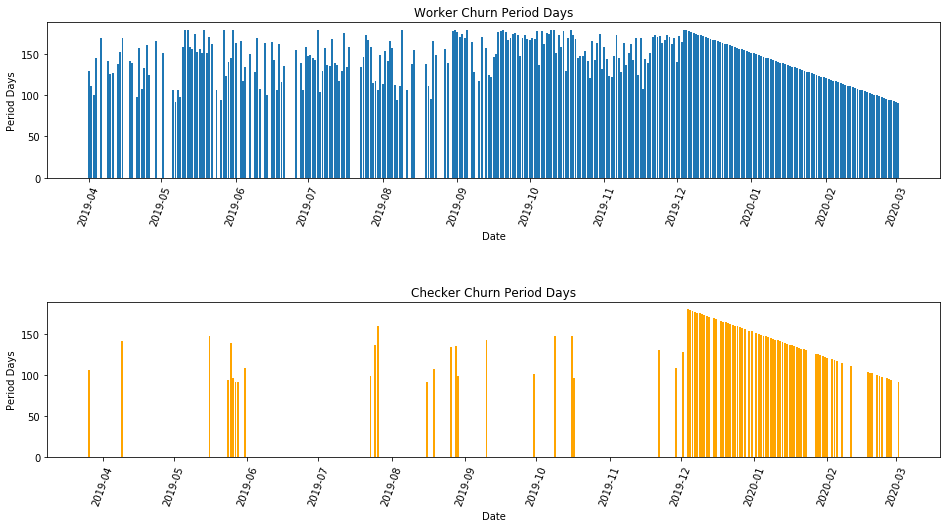

In [9]:
churn_worker_df.to_csv('./table/churn_worker_info.csv', index=False)
churn_checker_df.to_csv('./table/churn_checker_info.csv', index=False)

churn_worker_6mon = churn_worker_df[churn_worker_df['churn_period'] <= 180].reset_index(drop=True)
churn_checker_6mon = churn_checker_df[churn_checker_df['churn_period'] <= 180].reset_index(drop=True)

fig = plt.figure(figsize=(16,8))
# Worker
worker_peri_plot = fig.add_subplot(211)
fig.subplots_adjust(hspace=0.8)
worker_peri_plot.bar(
    churn_worker_6mon['churn_sdate'],
    churn_worker_6mon['churn_period'])
worker_peri_plot.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))
worker_peri_plot.xaxis.set_major_locator(mdates.MonthLocator())
plt.title("Worker Churn Period Days")
plt.xlabel('Date')
plt.ylabel('Period Days')
plt.xticks(rotation=70)
# Checker
checker_peri_plot = fig.add_subplot(212)
checker_peri_plot.bar(
    churn_checker_6mon['churn_sdate'],
    churn_checker_6mon['churn_period'],
    color='orange')
checker_peri_plot.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))
checker_peri_plot.xaxis.set_major_locator(mdates.MonthLocator())
plt.title("Checker Churn Period Days")
plt.xlabel('Date')
plt.ylabel('Period Days')
plt.xticks(rotation=70)

### 프로젝트 연관성

In [10]:
# display(fdf.head(5))
fdf['work_sdate'] = pd.to_datetime(fdf['work_sdate'])
work_date_list = fdf['work_sdate'].unique()

# 하루 단위 프로젝트 종류, 활성 작업자
daily_prj = fdf.groupby(by=['work_sdate', 'prj_idx'], as_index=False).count()[['work_sdate', 'prj_idx']]
dau = fdf.groupby(by=['work_sdate', 'work_user'], as_index=False).count()[['work_sdate', 'work_user']]

# daily active user counts
dau_vc = dau['work_sdate'].value_counts().sort_index()
# daily project value counts
prj_vc = daily_prj['work_sdate'].value_counts().sort_index()

prjfig = plt.figure(figsize=(24,8))
daily_prj_plot = prjfig.add_subplot(111)
# project count
daily_prj_plot.bar(
    prj_vc.index,
    prj_vc,
    color='green', label='project', alpha=0.5)
# churn_worker_count
daily_prj_plot.bar(
    churn_worker_vc.index,
    churn_worker_vc,
    color='red', label='churn_worker', alpha=0.5)
# active worker_count
daily_prj_plot.plot(
    dau_vc.index,
    dau_vc,
    color='blue', label='active_worker')

daily_prj_plot.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))
daily_prj_plot.xaxis.set_major_locator(mdates.MonthLocator())
plt.title("Daily Project Count")
plt.xlabel('Date')
plt.ylabel('Project')
plt.legend()
plt.xticks(rotation=70)



(array([737150., 737180., 737211., 737241., 737272., 737303., 737333.,
        737364., 737394., 737425., 737456., 737485., 737516., 737546.,
        737577.]), <a list of 15 Text xticklabel objects>)

하루 단위로 오픈된 프로젝트 개수, 참여한 작업자 수, 이탈 작업자 수(해당 일로부터 3개월간 프로젝트 참여 이력이 없는 작업자 수)를 카운팅 한 결과
- 오픈된 프로젝트 수가 적어지는 2019-11 --> 2020-11 기간동안 이탈 작업자가 증가함을 보임
- 활성 작업자가 증가함에따라 이탈 작업자도 증가하는 경향을 보임

### 시간대별 회원 등급

In [13]:
time_grade = pd.read_csv('./table/analy_grade_raw.csv')
time_grade = time_grade.drop(time_grade.columns[0], axis=1)

for t in ['work_edate', 'check_edate']:
    time_grade[t] = pd.to_datetime(pd.to_datetime(time_grade[t])).dt.date
    
print(time_grade.shape)
    
display(time_grade.head(5))

(7073363, 8)


work_user  work_point    work_at  work_edate  check_user  check_point  \
0    38697.0        20.0     1060.0  2020-06-01    128586.0          0.0   
1    37324.0       100.0  2391147.0  2020-06-01         0.0          0.0   
2    38697.0        20.0     1040.0  2020-05-31    128586.0          0.0   
3   160697.0        20.0      820.0  2020-05-31    126789.0          0.0   
4    38697.0        20.0     1020.0  2020-05-31    128586.0          0.0   

   check_at check_edate  
0       0.0  2020-06-01  
1      -1.0         NaT  
2       0.0  2020-06-01  
3       0.0  2020-06-01  
4       0.0  2020-06-01

In [14]:
# 누적 포인트에 따른 회원 등급
def return_grade(point_list):
    grade_list = []
    for point in point_list:
        grade = 'STARTER'
        if point >= 1000000:
            grade = 'GOLD_PLUS'
        elif 1000000 > point >= 500000:
            grade = 'GOLD'
        elif 500000 > point >= 100000:
            grade = 'SILVER_PLUS'
        elif 100000 > point >= 50000:
            grade = 'SILVER'
        elif 50000 > point >= 10000:
            grade = 'BRONZE_PLUS'
        elif 10000 > point >= 5000:
            grade = 'BRONZE'
        
        grade_list.append(grade)
        
    return grade_list

In [15]:
time_grade['work_grade'] = return_grade(time_grade['work_at'])
time_grade['check_grade'] = return_grade(time_grade['check_at'])
time_grade.head(5)


work_user  work_point    work_at  work_edate  check_user  check_point  \
0    38697.0        20.0     1060.0  2020-06-01    128586.0          0.0   
1    37324.0       100.0  2391147.0  2020-06-01         0.0          0.0   
2    38697.0        20.0     1040.0  2020-05-31    128586.0          0.0   
3   160697.0        20.0      820.0  2020-05-31    126789.0          0.0   
4    38697.0        20.0     1020.0  2020-05-31    128586.0          0.0   

   check_at check_edate work_grade check_grade  
0       0.0  2020-06-01    STARTER     STARTER  
1      -1.0         NaT  GOLD_PLUS     STARTER  
2       0.0  2020-06-01    STARTER     STARTER  
3       0.0  2020-06-01    STARTER     STARTER  
4       0.0  2020-06-01    STARTER     STARTER

In [16]:
wgrade_df = time_grade[['work_user', 'work_at', 'work_edate', 'work_grade']]
cgrade_df = time_grade[['check_user', 'check_at', 'check_edate', 'check_grade']]
print(wgrade_df.shape, cgrade_df.shape)

wgrade_df = wgrade_df.dropna()
cgrade_df = cgrade_df.dropna()
print()
print('Drop null')
print(wgrade_df.shape, cgrade_df.shape)

# rename for merge
wgrade_df = wgrade_df.rename(columns={'work_edate': 'churn_sdate', 'work_user': 'member_id'})
cgrade_df = cgrade_df.rename(columns={'check_edate': 'churn_sdate', 'check_user': 'member_id'})
display(wgrade_df.head(5), cgrade_df.head(5))
print('churn worker, checker: ', wgrade_df.shape, cgrade_df.shape)
print()

# Churn
for d in ['churn_sdate', 'churn_edate', 'reg_date']:
    churn_worker_df[d] = str(churn_worker_df[d])
    
# wgrade_df = pd.merge(wgrade_df, churn_worker_df[['member_id', 'churn_sdate', 'churn_edate', 'reg_date']],
#                      on=['member_id', 'churn_sdate'])

display(wgrade_df.head(10))
print(wgrade_df.shape)



(7073363, 4) (7073363, 4)

Drop null
(7068692, 4) (6538808, 4)


member_id    work_at churn_sdate work_grade
0    38697.0     1060.0  2020-06-01    STARTER
1    37324.0  2391147.0  2020-06-01  GOLD_PLUS
2    38697.0     1040.0  2020-05-31    STARTER
3   160697.0      820.0  2020-05-31    STARTER
4    38697.0     1020.0  2020-05-31    STARTER

member_id  check_at churn_sdate check_grade
0   128586.0       0.0  2020-06-01     STARTER
2   128586.0       0.0  2020-06-01     STARTER
3   126789.0       0.0  2020-06-01     STARTER
4   128586.0       0.0  2020-06-01     STARTER
6   126789.0       0.0  2020-06-01     STARTER

churn worker, checker:  (7068692, 4) (6538808, 4)



member_id    work_at churn_sdate work_grade
0    38697.0     1060.0  2020-06-01    STARTER
1    37324.0  2391147.0  2020-06-01  GOLD_PLUS
2    38697.0     1040.0  2020-05-31    STARTER
3   160697.0      820.0  2020-05-31    STARTER
4    38697.0     1020.0  2020-05-31    STARTER
5    37324.0  2391097.0  2020-05-31  GOLD_PLUS
6   160697.0      800.0  2020-05-31    STARTER
7    37324.0  2391072.0  2020-05-31  GOLD_PLUS
8    38697.0     1000.0  2020-05-31    STARTER
9    37324.0  2391022.0  2020-05-31  GOLD_PLUS

(7068692, 4)


In [ ]:
churn_worker_df
churn_checker_df

### 로그인 히스토리

In [ ]:
login_df = pd.read_csv('./table/login_hist.csv')
print('login_hist table shape: ', login_df.shape)

# pre-processing
for i in ['login_date', 'logout_date']:
    login_df[i] = pd.to_datetime(pd.to_datetime(login_df[i]).dt.date)
    
login_df = login_df[login_df['login_date'] < '2020-06-01 00:00:00'].reset_index(drop=True)
login_df.head(5)

In [ ]:
# Total worker, checker list
print('전체 활동 작업자: ', len(worker_list))
print('전체 활동 검수자: ', len(checker_list))

# Unique churn member
print()
print('이탈 작업자: ', len(unique_churn_worker))
print('이탈 검수자: ', len(unique_churn_checker))

# Login member
print()
unq_login_members = login_df['member_id'].unique()
print('로그인 이력이 있는 회원 수', len(unq_login_members))

err_w = 0
err_c = 0
for w in worker_list:
    if w not in unq_login_members:
        err_w += 1
        
for c in checker_list:
    if c not in unq_login_members:
        err_c += 1
        
print(err_w, err_c)
        